In [1]:
# Load modules
import numpy as np
import psyplot.project as psy
import cmcrameri.cm as cmc
import cartopy.feature as cf
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import sys

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

In [2]:
# Get example datasets for testing (won't do anything if data is already downloaded)
iconvis.get_example_data()

('/', 'scratch-shared', 'meteoswiss', 'scratch', 'vcherkas', 'icon-vis', 'difference_map')
 
Getting data from folder: grib
 
Getting data from folder: grids
 
Getting data from folder: nc


In [3]:
f1 = '../data/example_data/nc/my_exp1_atm_3d_ml_20180921T000000Z.nc'
f2 = '../data/example_data/nc/my_exp1_diff.nc'

data1 = psy.open_dataset(f1)
data2 = psy.open_dataset(f2)

In [4]:
var = 'u'
height_ind = 60 #If var is not 2 dimensional
values1 = data1[var].values[:,height_ind,:]
values2 = data2[var].values[:,height_ind,:]

In [5]:
# Calculate mean, difference and p-values
var1_mean,var2_mean,var_diff,var_pval=iconvis.get_stats(values1,values2)

In [6]:
# Create new dataset, which contains the mean var_diff values
data3 = xr.Dataset(
     data_vars=dict(
         var_diff=(["ncells"], var_diff)
     ),
     coords=dict(
         clon=(["ncells"], data1.clon.values[:]),
         clon_bnds=(["ncells","vertices"], data1.clon_bnds.values[:]),
         clat=(["ncells"], data1.clat.values[:]),
         clat_bnds=(["ncells","vertices"], data1.clat_bnds.values[:]),
         time=(["time"], data1.time.values[:]),
     )
 )
data3["clon"].attrs["bounds"] = "clon_bnds"
data3["clat"].attrs["bounds"] = "clat_bnds"
data3["clon"].attrs["units"] = "radian"
data3["clat"].attrs["units"] = "radian"
data3.var_diff.encoding['coordinates'] = 'clat clon'

In [7]:
# show figures after they are drawn or updated
psy.rcParams['auto_show'] = True
# dont show x or y grid lines
psy.rcParams["plotter.maps.xgrid"] = False
psy.rcParams["plotter.maps.ygrid"] = False

%matplotlib inline
%config InlineBackend.close_figures = False

/users/vcherkas/miniconda3/envs/psyplot/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


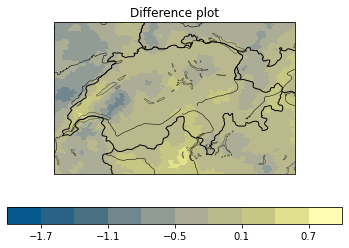

In [8]:
# create psyplot instance
# name: name of variable
# projection: e.g. robin
# title: title of plot
# map_extent: borders of map (example for Switzerland)
lonmin = 5.8
lonmax = 10.7
latmin = 45.5
latmax = 48.0

pp = psy.plot.mapplot(data3,
    name = 'var_diff',
    projection = 'robin',
    map_extent = [lonmin, lonmax, latmin, latmax],
    title = 'Difference plot',
    cmap = 'cmc.nuuk',
    lakes=True,
    borders=True,
    rivers=True
    )

/users/vcherkas/miniconda3/envs/psyplot/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


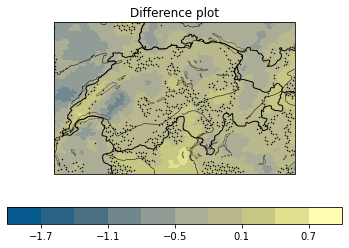

In [9]:
# Add dots for insignificant values
lats = np.rad2deg(data3.clat.values[:])
lons = np.rad2deg(data3.clon.values[:])
pos_lon,pos_lat = iconvis.add_coordinates(lons,lats,lonmin,lonmax,latmin,latmax)

fig = plt.gcf()
pval_insig = np.argwhere((np.isnan(var_pval)) | (var_pval>0.05))
for i in pval_insig:
    fig.axes[0].plot(pos_lon[i], pos_lat[i],'k',marker='o', markersize=0.5, transform=fig.axes[0].transAxes)
pp.update()

In [10]:
# Account for dependency of data points
alpha = 0.05
pfdr = iconvis.wilks(var_pval, alpha)

/users/vcherkas/miniconda3/envs/psyplot/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


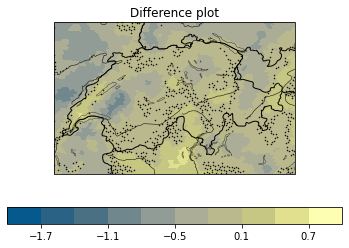

In [11]:
pp_new = psy.plot.mapplot(data3,
    name = 'var_diff',
    projection = 'robin',
    map_extent = [lonmin, lonmax, latmin, latmax],
    title = 'Difference plot',
    cmap = 'cmc.nuuk',
    lakes=True,
    borders=True,
    rivers=True
    )

fig = plt.gcf()
pfdr_insig = np.argwhere((np.isnan(var_pval)) | (var_pval>pfdr))
for i in pfdr_insig:
    fig.axes[0].plot(pos_lon[i], pos_lat[i],'k',marker='o', markersize=0.5, transform=fig.axes[0].transAxes)